<a href="https://colab.research.google.com/github/E-leg/Project_Tropical_Cyclones/blob/main/tc_sar_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery


## Introduction

### Description

The dataset consists of 341 files in one global xarray.Dataset stored in .zarr format. Each file contains a SAR acquisition of one TC at one instant time, as well as the computed wind field associated with the satellite signal. Each file also contains additional information, such as the storm name, ID, and category (= category at the time of the acquisition).

The specificity of this dataset (compared to other TC datasets) is its spatial resolution, which reaches 1 km in both x and y directions. The counterpart is its temporal resolution, which is very low: TC images are acquired when the (polar-orbiting) satellite overpasses a TC (and only if the operational chain decided to put the sensor on at this moment), which leads to an irregular sampling in time. 

The goal of the project is to compute some statistical properties about the TCs of the dataset. This includes statistics about:

- GROUP 1: covariance matrix of the wind fields by Saffir-Simpson category;

- GROUP 2: spatial and temporal coverage of the TCs (basins, seasons), mean wind field by Saffir-Simpson category, as well as statistical distribution of some important metrics (Vmax, Rmax, R64, R50, R34);

### Imports 

In [1]:
### INSTALLATION
!pip install --upgrade pyyaml==5.4.1 tqdm gcsfs zarr dask xarray scipy datetime

     |████████████████████████████████| 636 kB 5.4 MB/s 
     |████████████████████████████████| 146 kB 51.3 MB/s 
     |████████████████████████████████| 1.0 MB 41.8 MB/s 
     |████████████████████████████████| 845 kB 47.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 60 kB 6.4 MB/s 
     |████████████████████████████████| 133 kB 47.5 MB/s 
     |████████████████████████████████| 1.1 MB 49.3 MB/s 
     |████████████████████████████████| 160 kB 55.7 MB/s 
     |████████████████████████████████| 271 kB 60.6 MB/s 
     |████████████████████████████████| 192 kB 56.6 MB/s 
     |████████████████████████████████| 6.2 MB 15.9 MB/s 
     |████████████████████████████████| 251 kB 49.3 MB/s 
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5050 sha256=311aa456315fb3d80a6b85838dd5c3053c84db82a98bfe98f390cff739327723
  Stored in directory: /root/.cache/pip/wheels/12/1c/38/0def51e15add93bff3f4bf9c248b94db0839b9

In [2]:
from tqdm import tqdm
import gcsfs
import zarr
import dask as da

import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from scipy.interpolate import griddata
from datetime import datetime

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
from tqdm import tqdm
import gcsfs
import zarr
import dask as da
from collections import Counter

# import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

from scipy.interpolate import griddata
from datetime import datetime
from numpy.linalg import eig

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

### Dataset

In [4]:
# OPEN DATASET
fs     = gcsfs.GCSFileSystem(project='ds2class-2021', token='anon', access='read_only')
gcsmap = fs.get_mapper("project10_tc_sar/zarr_data/tc_sar_data.zarr")
ds_all = xr.open_zarr(gcsmap)
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

### Plot functions

In [5]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    '''Given an xarray.Dataset object containing all the files (e.g 341) and a time index, plots the corresponding TC wind field using plt.pcolormesh().'''
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                   # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3

# plot_wind_field(ds_all, time_idx=4)

In [6]:
def plot_wind_fields(ds_all, start_index):
    # Open figure
    plt.figure(figsize=(25,20))
    
    for ind,i in enumerate(range(start_index, min(start_index+16,len(ds_all.time)))):
        plt.subplot(4,4,ind+1)

        # Title
        name = ds_all.isel(time=i)['storm_name'].values
        tcId = ds_all.isel(time=i)['storm_id'].values
        cat  = int(ds_all.isel(time=i)['cat'])
        plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
        
        # Plot
        x, y = np.meshgrid(ds_all.isel(time=i)['x'], ds_all.isel(time=i)['y']) # Defining 2D coordinates
        plt.pcolormesh(x, y, ds_all.isel(time=i)['wind_speed'])                       # Plot the wind field
        plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                   # Add axis legend
        # plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
        # cbar = plt.colorbar()                                                                # Colorbar - line 2
        # cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3
    
    plt.tight_layout()
    plt.show()

# plot_wind_fields(ds_all,0)

In [7]:
def plot_polar(ds_all,time_idx,r_max=70000):
    x = ds_all.isel(time=time_idx)['r']
    y = ds_all.isel(time=time_idx)['theta']
    z = ds_all.isel(time=time_idx)['wind_speed']
    ax = plt.subplot(projection="polar")
    ax.set_theta_zero_location("N")
    ax.pcolormesh(y,x,z)
    ax.set_rmax(r_max)
    ax.grid(True)

## Cartesian Coordinates

### Covariance

In [ ]:
# Get category for each image
cats = ds_all.cat.to_numpy()
Counter(cats)

Counter({0: 92, 1: 82, 2: 41, 3: 55, 4: 54, 5: 17})

In [ ]:
# Process dataset and get wind speed data
i_pix = 250000
crop_ds_all = ds_all.sel(x=slice(-i_pix, i_pix-1), y=slice(-i_pix, i_pix-1)) # Crop

n = 10
wind_speed = crop_ds_all.wind_speed[:,::n,::n].to_numpy() # Reduce data
wind_speed.shape

(341, 50, 50)

In [ ]:
plt.figure()
plt.plot()

In [ ]:
# Vectorize data
X = wind_speed.reshape(wind_speed.shape[0],-1)
X.shape

(341, 2500)

In [ ]:
# Group data by category
X_by_cat = [X[cats == i] for i in range(cats.max()+1)]
len(X_by_cat)

6

In [ ]:
# Center data
Xc_by_cat = [x - np.nanmean(x, axis=0) for x in X_by_cat]

# Compute covariance
compute_cov = lambda X : np.nanmean(np.array([np.outer(x,x) for x in X]), axis=0)
Cov_by_cat = [compute_cov(Xc) for Xc in Xc_by_cat]

Cov_by_cat[0].shape

In [ ]:
# Category
nc = 0

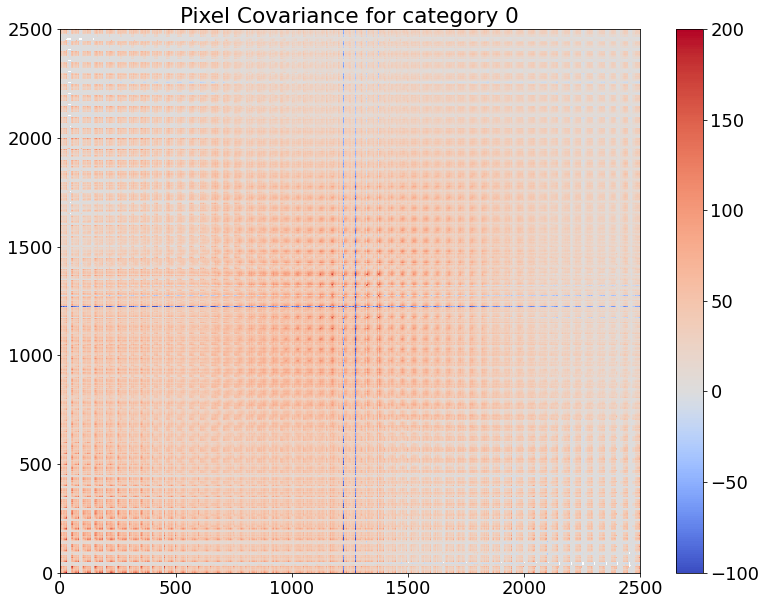

In [ ]:
# Plot covariance Matrix
plt.figure(figsize=(13,10))
plt.title(f'Pixel Covariance for category {nc}')
divnorm = colors.TwoSlopeNorm(vmin=-100, vcenter=0., vmax=200)
plt.pcolormesh(Cov_by_cat[nc], cmap="coolwarm", norm=divnorm)
plt.colorbar()
plt.show()
# Keep same clim for all cats

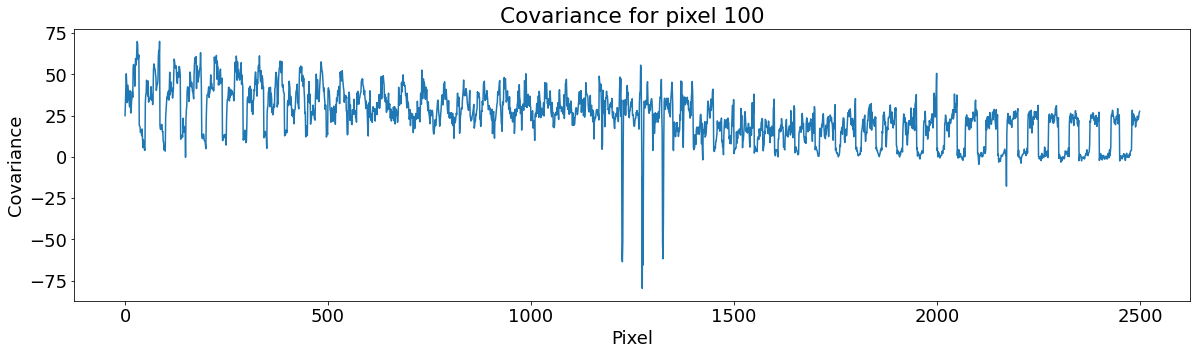

In [ ]:
# Plot covariance for one pixel
rand_index = 100
plt.figure(figsize=(20,5))
plt.plot(Cov_by_cat[nc][rand_index])
plt.title(f'Covariance for pixel {rand_index}')
plt.xlabel('Pixel')
plt.ylabel('Covariance')
plt.show()

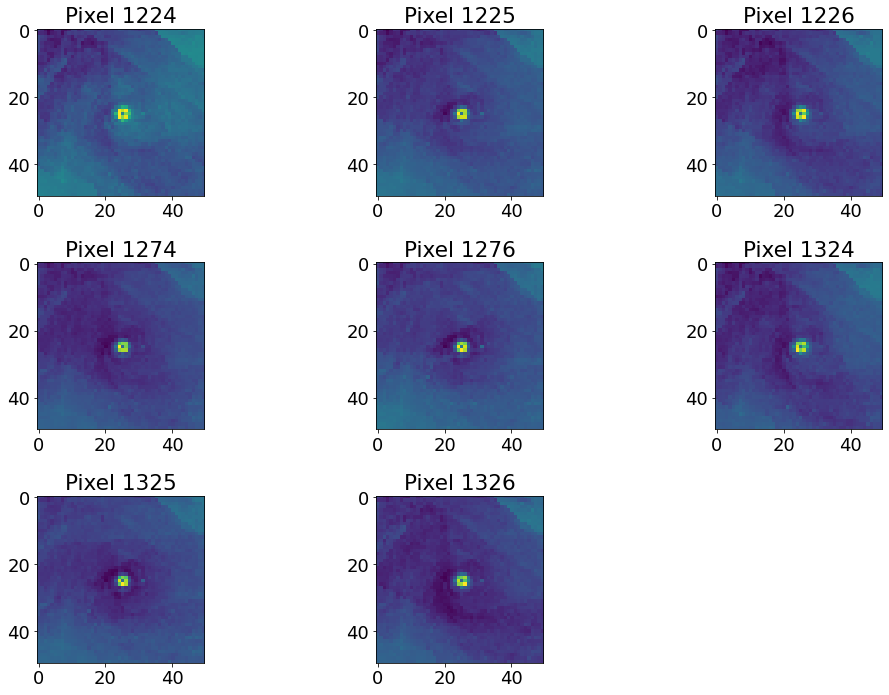

In [ ]:
# Plot covariance for pixel from blue line
threshold = -25
for i,ind in enumerate(np.where(Cov_by_cat[nc][rand_index] < threshold)[0]):
    plt.subplot(3,3,i+1)
    plt.title(f'Pixel {ind}')
    im = Cov_by_cat[nc][ind].reshape(50,50)
    plt.imshow(im)
plt.tight_layout()
plt.show()

In [ ]:
# Plot pixels cov not from middle
im = Cov_by_cat[nc][100].reshape(50,50)
plt.imshow(im)

### PCA

In [ ]:
# Eigen decomposition of covariance matrix
values, vectors = eig(np.nan_to_num(Cov_by_cat[nc]))
print(vectors.shape)
print(values.shape)

(2500, 2500)
(2500,)


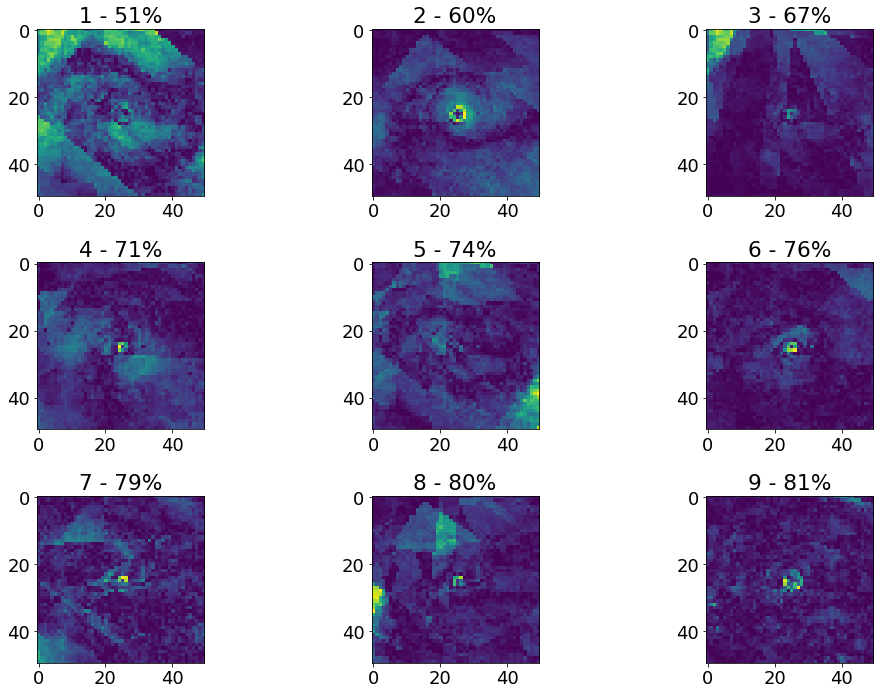

In [ ]:
# Plot the first eigen vectors
plt.figure()
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(abs(vectors.T[i,:]).reshape(50,50))
    explained_var = int(round((np.cumsum(abs(values[:i]))[-1] / abs(values).sum())*100))
    plt.title(f'{i} - {explained_var}%')
plt.tight_layout()
plt.show()

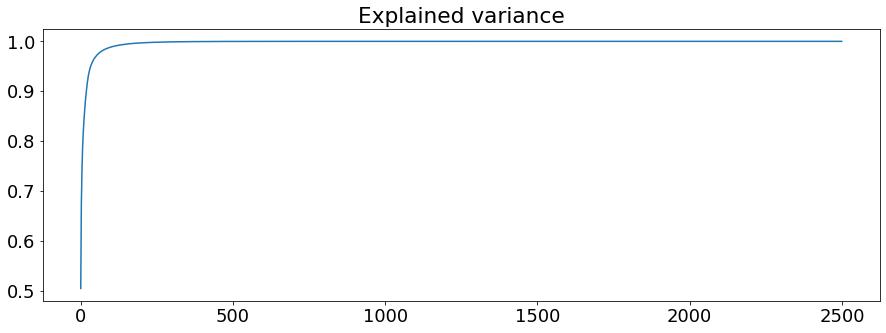

In [ ]:
# Explained variance
plt.figure(figsize=(15,5))
plt.title("Explained variance")
plt.plot(np.arange(len(v)), np.cumsum(abs(values)) / abs(values).sum())
plt.show()

In [ ]:
# Project data
P = np.dot(vectors.T, X_by_cat[nc].T)
P.shape

(2500, 92)

## Polar Coordinates

### Add Polar Coordinates

In [8]:
ds_all = ds_all.assign(r = lambda d : np.sqrt(d.x**2 + d.y**2))
ds_all = ds_all.assign(theta = lambda d : np.arctan2(d.y,d.x)) # Put zero on top
ds_all

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/37)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    r                                              (x, y) float64 7.057e+05 ....
    theta                                          (y, x) float64 -2.356 ... ...

### Max wind speed

In [225]:
# Crop
i_pix = 200000
crop_ds_all = ds_all.sel(x=slice(-i_pix, i_pix-1), y=slice(-i_pix, i_pix-1)) # Crop

In [ ]:
# Get xy indexes for max wind speed
x_max_indexes = crop_ds_all.wind_speed.argmax(dim=["x", "y"], skipna=True)["x"].to_numpy()
y_max_indexes = crop_ds_all.wind_speed.argmax(dim=["x", "y"], skipna=True)["y"].to_numpy()

In [ ]:
# Get coordinates and values for max wind speed
cyclone_indexes = np.arange(len(crop_ds_all.time))

rmaxs = np.array([crop_ds_all.r.isel(x=x_max_indexes[i], y=y_max_indexes[i]).values for i in cyclone_indexes])
thetamaxs = np.array([crop_ds_all.theta.isel(x=x_max_indexes[i], y=y_max_indexes[i]).values for i in cyclone_indexes])
xmaxs = np.array([crop_ds_all.x[x_max_indexes[i]].values for i in cyclone_indexes])
ymaxs = np.array([crop_ds_all.y[y_max_indexes[i]].values for i in cyclone_indexes])
wind_speed_maxs = np.array([crop_ds_all.wind_speed.isel(x=x_max_indexes[i], y=y_max_indexes[i], time=i).values for i in cyclone_indexes])

In [ ]:
# Plot by category
plt.plot(wind_speed_maxs[cats==5])

In [ ]:
# Plot multiple results
start_index=251

plt.figure(figsize=(25,20))

for ind,i in enumerate(range(start_index, min(start_index+4,len(crop_ds_all.time)))):
    plt.subplot(2,2,ind+1)

    # Title
    name = crop_ds_all.isel(time=i)['storm_name'].values
    tcId = crop_ds_all.isel(time=i)['storm_id'].values
    cat  = int(crop_ds_all.isel(time=i)['cat'])
    plt.title('%i - SAR wind field\n%s, %s, Cat. %i'%(i, name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(crop_ds_all.isel(time=i)['x'], crop_ds_all.isel(time=i)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, crop_ds_all.isel(time=i)['wind_speed'])                       # Plot the wind field
    plt.scatter(ymaxs[i], xmaxs[i], c='r')
    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                   # Add axis legend

plt.tight_layout()
plt.show()

### Max wind speed intervals

In [9]:
r = ds_all.r.to_numpy().flatten()

def compute_rmax(t, s=2000, n=75):
    w = ds_all.isel(time=t).wind_speed.to_numpy().flatten()
    intervals = [(r > i*s)*(r < (i+1)*s) for i in range(n)]
    i_max_mean = np.argmax([np.nanmean(w[i]) for i in intervals])
    i_max_median = np.argmax([np.nanmedian(w[i]) for i in intervals])
    r_max_mean = r[intervals[i_max_mean]].mean() # Use argmax ?
    r_max_median = r[intervals[i_max_median]].mean()
    return r_max_mean, r_max_median

In [ ]:
### PLOTTING WIND FIELDS
def plot_wind_field_rmaxs(ds_all, time_idx):
    '''Given an xarray.Dataset object containing all the files (e.g 341) and a time index, plots the corresponding TC wind field using plt.pcolormesh().'''
    # Open figure
    fig, ax = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.scatter(ymaxs[time_idx], xmaxs[time_idx], c='r')
    r_max_mean, r_max_median = rmax(time_idx, s=5000, n=60)
    circle1 = plt.Circle((0, 0), r_max_mean, color='r', fill=False)
    ax.add_patch(circle1)
    circle2 = plt.Circle((0, 0), r_max_median, color='b', fill=False)
    ax.add_patch(circle2)

    plt.xlabel('x (m)');plt.ylabel('y (m)');plt.grid()                                   # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3

plot_wind_field_rmaxs(ds_all, 4)

In [ ]:
def rmax_theta_max(ds_all, time_idx, r_max=70000, r_recherche=20000):
    rayons = ds_all.isel(time=time_idx)['r'].to_numpy().flatten()
    vitesses = ds_all.isel(time=time_idx)['wind_speed'].to_numpy().flatten()
    thetas = ds_all.isel(time=time_idx)['theta'].to_numpy().flatten()
    intervalle_max = 0
    v_anneau_max = 0

    for i in range(int(np.max(rayons)//r_recherche)+1):
      v = np.nansum(vitesses[(rayons<(i+1)*r_recherche) * (rayons>(i)*r_recherche)])/(np.product(vitesses[(rayons<(i+1)*r_recherche) * (rayons>(i)*r_recherche)].shape))
      if v>v_anneau_max:
        v_anneau_max = v
        r_maximum = rayons[(rayons<(i+1)*r_recherche) * (rayons>(i)*r_recherche)][np.argmax(vitesses[(rayons<(i+1)*r_recherche) * (rayons>(i)*r_recherche)])]
        theta_maximum = thetas[(rayons<(i+1)*r_recherche) * (rayons>(i)*r_recherche)][np.argmax(vitesses[(rayons<(i+1)*r_recherche) * (rayons>(i)*r_recherche)])]
    
    return r_maximum, theta_maximum

In [ ]:
def plot_polar_rmax(ds_all, time_idx, r_maximum, theta_maximum, r_max=70000):
    x = ds_all.isel(time=time_idx)['r']
    y = ds_all.isel(time=time_idx)['theta']
    z = ds_all.isel(time=time_idx)['wind_speed']
    
    ax = plt.subplot(projection="polar", polar=True)
    ax.set_theta_zero_location("N")
    ax.pcolormesh(y,x,z)
    plt.scatter(theta_maximum,r_maximum, s=100, c='r')
    circle_rmax = plt.Circle((0,0), r_maximum,transform=ax.transData._b, color='r', alpha=0.2, fill=True)
    ax.add_artist(circle_rmax)

    ax.set_rmax(r_max)
    ax.grid(True)

In [ ]:
time_idx = 15
r_maximum, theta_maximum = rmax_theta_max(ds_all, time_idx)
plot_polar(ds_all, time_idx, r_maximum, theta_maximum, r_max=150000)

### Interpolation

#### Introduction

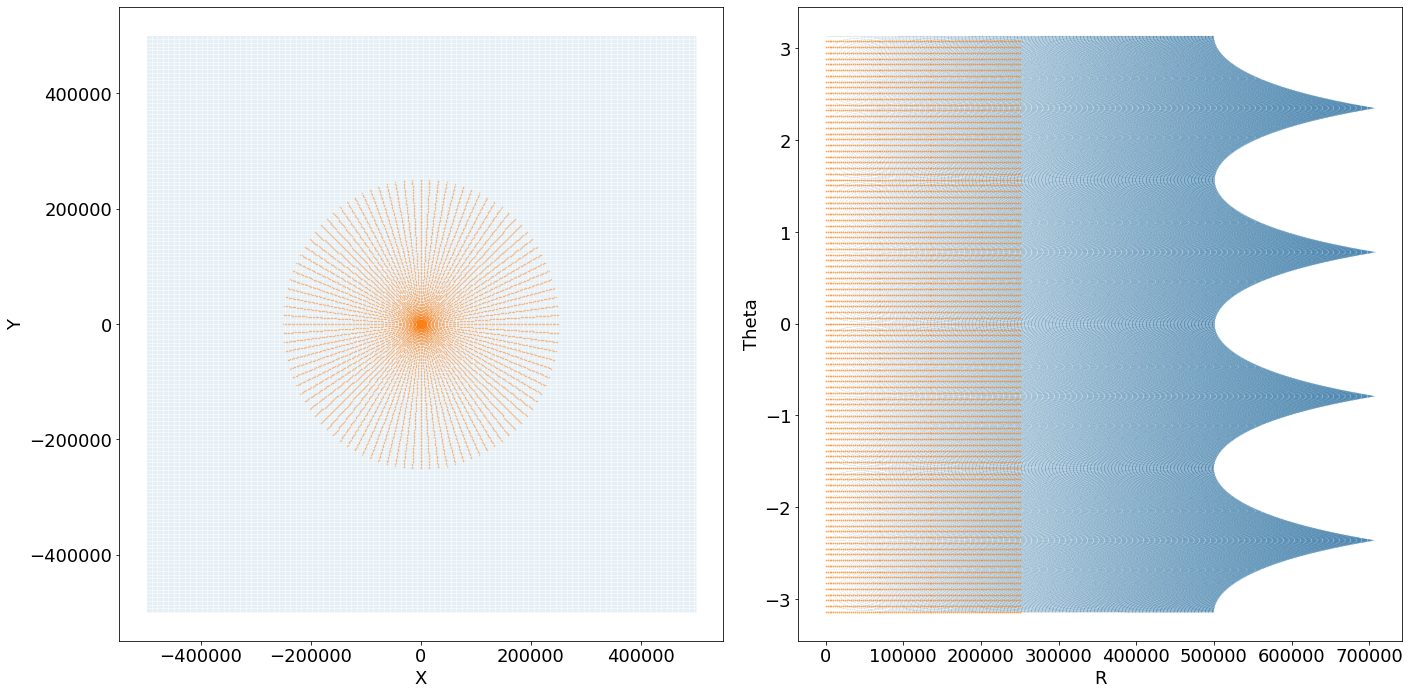

In [22]:
Rmax = 250000
n_r, n_th = 100, 100
grid_R, grid_Th = np.mgrid[0:Rmax:complex(0,n_r), -np.pi:np.pi-2*np.pi/n_th:complex(0,n_th)]

X = grid_R * np.cos(grid_Th)
Y = grid_R * np.sin(grid_Th)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
# plt.scatter(X[:p//2,-1], Y[p//4:-p//4,-1], s=0.02)
plt.scatter(*np.meshgrid(ds_all.x, ds_all.y), s=0.0001)
plt.scatter(X, Y, s=0.2, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1,2,2)
plt.scatter(ds_all.r, ds_all.theta, s=0.001)
plt.scatter(grid_R, grid_Th, s=1, alpha=0.5)
plt.xlabel('R')
plt.ylabel('Theta')

plt.tight_layout()
plt.show()

In [75]:
# grid_w = np.zeros_like(X)
# w = ds_all.isel(time=0).wind_speed
# for i,(x_,y_) in tqdm(enumerate(zip(X,Y))):
#     for j,(x,y) in enumerate(zip(x_,y_)):
#         grid_w[i,j] = w.sel(x=x, y=y, method="nearest").values

100it [02:20,  1.40s/it]


#### No normalization

In [22]:
xy_res = 1000
Rmax = 250000
p_r, p_th = 100, 100
grid_R, grid_Th = np.mgrid[0:Rmax:complex(0,p_r), -np.pi:np.pi:complex(0,p_th)]

X_target = grid_R * np.cos(grid_Th)
Y_target = grid_R * np.sin(grid_Th)

X_source, Y_source = np.meshgrid(ds_all.x.sel(x=slice(-Rmax-xy_res, Rmax+xy_res)).values, ds_all.y.sel(y=slice(-Rmax-xy_res, Rmax+xy_res)).values)

points = np.c_[X_source.flatten(), Y_source.flatten()]
wind_values_xy = ds_all.isel(time=15).wind_speed.sel(x=slice(-Rmax-xy_res, Rmax+xy_res), y=slice(-Rmax-xy_res, Rmax+xy_res)).values.flatten()

GG = griddata(points, wind_values_xy, (X_target, Y_target), method='nearest')

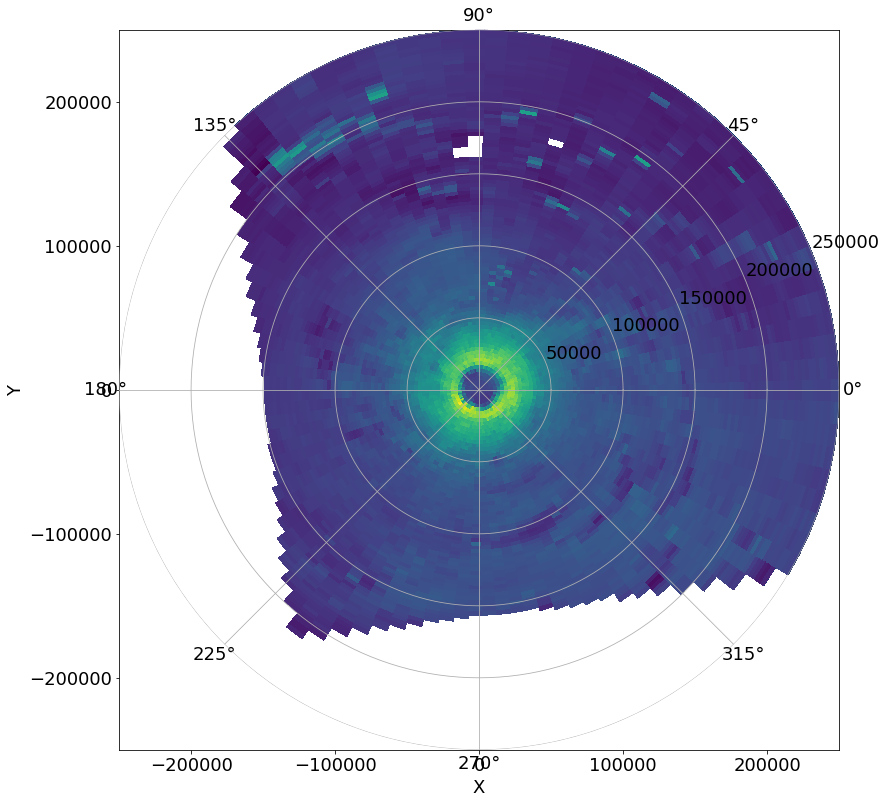

In [23]:
# initializing the figure
fig = plt.figure(figsize=(10,10))
# setting the axis limits in [left, bottom, width, height]
rect = [-1, -1, 1, 1]

# the carthesian axis:
ax_carthesian  = fig.add_axes(rect)
# the polar axis:
ax_polar = fig.add_axes(rect, polar=True, frameon=False)

# plotting the line on the carthesian axis
ax_carthesian.pcolormesh(X_target, Y_target, GG, alpha=1, cmap='cividis')
ax_carthesian.set_xlabel('X')
ax_carthesian.set_ylabel('Y')

# the polar plot
ax_polar.pcolormesh(grid_Th, grid_R, GG, alpha=1)
# ax_polar.set_rmax(2.0)
ax_polar.grid(True)

plt.show()

#### Rmax normalization

In [17]:
time_i = 134
xy_res = 1000
Rmax = 250000

r_ratio_max = 8
p_r, p_th = 100, 100
grid_R, grid_Th = np.mgrid[0:r_ratio_max:complex(0,p_r), -np.pi:np.pi:complex(0,p_th)]

X_target = grid_R * np.cos(grid_Th)
Y_target = grid_R * np.sin(grid_Th)

X_source, Y_source = np.meshgrid(ds_all.x.sel(x=slice(-Rmax-xy_res, Rmax+xy_res)).values, ds_all.y.sel(y=slice(-Rmax-xy_res, Rmax+xy_res)).values)

rmax_i = compute_rmax(time_i)[0]

points = np.c_[X_source.flatten(), Y_source.flatten()] / rmax_i
wind_values_xy = ds_all.isel(time=time_i).wind_speed.sel(x=slice(-Rmax-xy_res, Rmax+xy_res), y=slice(-Rmax-xy_res, Rmax+xy_res)).values.flatten()

GG = griddata(points, wind_values_xy, (X_target, Y_target), method='nearest')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


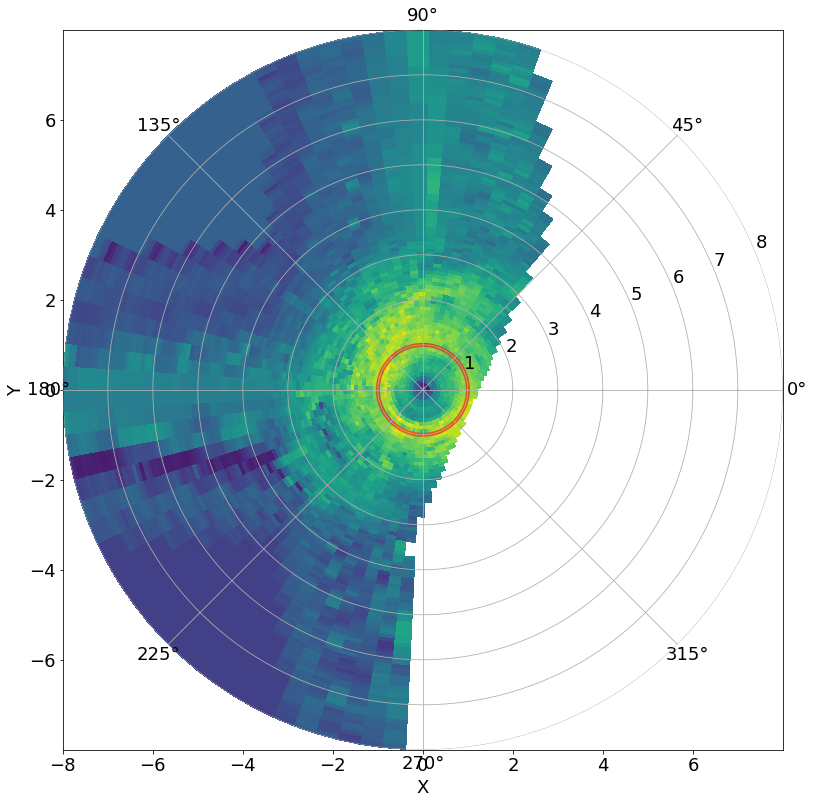

In [18]:
# initializing the figure
fig = plt.figure(figsize=(10,10))
# setting the axis limits in [left, bottom, width, height]
rect = [-1, -1, 1, 1]

# the carthesian axis:
ax_carthesian  = fig.add_axes(rect)
# the polar axis:
ax_polar = fig.add_axes(rect, polar=True, frameon=False)

# plotting the line on the carthesian axis
ax_carthesian.pcolormesh(X_target, Y_target, GG, alpha=1)
ax_carthesian.set_xlabel('X')
ax_carthesian.set_ylabel('Y')

# the polar plot
ax_polar.pcolormesh(grid_Th, grid_R, GG, cmap='cividis', alpha=0)
# ax_polar.set_rmax(2.0)
ax_polar.grid(True)

ax = fig.add_axes(rect)
circle_rmax = plt.Circle((0,0), 1,transform=ax.transData._b, color='r', alpha=0.6, fill=False, lw=4, zorder=2)
ax.add_artist(circle_rmax)

plt.show()